# Baseline CRNN Model + CTC loss function to crack Captcha OCR problem

This is the baseline to crack/solve the CAPTCHA image OCR problem without worrying about character segmentation.

In [53]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import json

# make sure we use tensorflow 2.0
import tensorflow as tf
print(tf.__version__)

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2.6.0


In [54]:
DATASET_ZIP_PATH="data/raw.zip"
import zipfile
with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("captcha_project")

In [55]:
!ls

CRNN_captcha.ipynb  captcha_project  data  logs


In [56]:
# finding where we are so we dont need to type absolute path everytime
# current_directory_path = pathlib.Path(".").absolute()
current_directory_path = pathlib.Path("./captcha_project")
current_directory_path

PosixPath('captcha_project')

In [57]:
# path to our directory images

# our raw folders
RAW_FOLDER = os.path.join(current_directory_path, "raw")

In [58]:
print(RAW_FOLDER)

captcha_project/raw


In [59]:
# we working on localhost or VM Cloud for now so no need this code section
# from google.colab.patches import cv2_imshow #only in Colab because using cv2.imshow is not allowed in Colab
# from google.colab import drive
# drive.mount('/gdrive')

In [60]:
# checking if GPU is available 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # RIP Training time
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [61]:
#!ls ./captcha_project/raw

## Reading images and organise folders

In [62]:
# checking the total alphabet characters of the whole dataset
raw_data_path = pathlib.Path(RAW_FOLDER)
char_list= set()
dict_file_label={}
for item in raw_data_path.glob('*'):
    label = os.path.basename(os.path.splitext(item)[0])
    dict_file_label[str(item)]=label
    char_list.update(set((label)))
char_list=sorted(char_list)

print("Total number of characters : {}".format(len(char_list)))

Total number of characters : 32


In [63]:
#dict_file_label

In [64]:
# show all possible labels characters
"".join(char_list)

'23456789ABCDEFGHJKLMNPQRSTUVWXYZ'

In [65]:
# find the maximum label length
label_lens= []
for label in dict_file_label.values():
    label_lens.append(len(label))
max_label_len = max(label_lens)

In [66]:
# Only because this dataset is CAPTCHA so the length of all labels are 4.
max_label_len

4

In [67]:
# convert the words to array of indexs based on the char_list
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [68]:
# testing our encode function (text to number)
encode_to_labels("2345ABCDE") 

[0, 1, 2, 3, 8, 9, 10, 11, 12]

In [69]:
# all possible image paths for training
all_image_paths = list(dict_file_label.keys())

In [70]:
all_image_paths[:5]

['captcha_project/raw/EZAR.png',
 'captcha_project/raw/L4MJ.png',
 'captcha_project/raw/JS5J.png',
 'captcha_project/raw/KUD7.png',
 'captcha_project/raw/A5F8.png']

In [71]:
# find all widths and heights of images (this is useful if our dataset images got different sizes)
widths = []
heights = []
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    (height, width, _) = img.shape
    heights.append(height)
    widths.append(width)

In [72]:
min_height = min(heights)
max_height = max(heights)
min_width = min(widths)
max_width = max(widths)

In [73]:
# this information is useful for making decision for padding and resizing
(min_height, max_height, min_width, max_width)

(24, 24, 72, 72)

The result is (24, 24, 72, 72) for this dataset so it is definitely telling us 
that we don't need to resize the image at all. 
But imagine if the result is (a,b,c,d). Then we should resize all images to the height of a or b
Then padding horizontally following the new max width of resized images

In this case, our images got the same size so no need to do anything at all

In [74]:
# being a good Data Scientist, we need to have train set and test set
from sklearn.model_selection import train_test_split
test_size = 0.2
train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)

## Preprocessing

In [75]:
# Constants (we choose this number as we later discover that the output of our CNN is (1,9,512) from out input)
TIME_STEPS = 9

In [76]:
# TO DO LIST: BUILD THE PIPELINE FOR THE IMAGES, definitely this is super basic pipeline and can be improved

# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

i=0
for train_img_path in train_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)

    # in this dataset, we don't need to do any resize at all here.
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.
    
    label = dict_file_label[train_img_path]

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 
    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))

has processed trained 500 files
has processed trained 1000 files
has processed trained 1500 files
has processed trained 2000 files
has processed trained 2500 files
has processed trained 3000 files
has processed trained 3500 files
has processed trained 4000 files
has processed trained 4500 files
has processed trained 5000 files
has processed trained 5500 files
has processed trained 6000 files
has processed trained 6500 files
has processed trained 7000 files
has processed trained 7500 files


In [77]:
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for test_img_path in test_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)
    
    # in this dataset, we don't need to do any resize at all here.
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_file_label[test_img_path]

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed test {} files".format(i))

has processed test 500 files
has processed test 1000 files
has processed test 1500 files


In [78]:
# this is the most controversial part when our max_label_len should be set different or slightly smaller than TIME_STEPS
# but let stick to the conventional/normal way: we should to be the same with our TIME_STEPS
max_label_len = TIME_STEPS

In [79]:
# pad each output label to maximum text length, remember we did that so that we keep training with rnn consistent?
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

## Model Building

In [80]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=32 and width=128 
inputs = Input(shape=(24,72,1))
 
# convolution layer with kernel size (3,3)  #(24,72,64)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(12,36,64)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

#(12,36,128)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(6,18,128)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

#(6,18,256)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

# poolig layer with kernel size (2,2) to make the height/2  #(3,9,256)
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

batch_norm_3 = BatchNormalization()(pool_3)

#(3,9,256)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)

# Batch normalization layer #(3,9,256)
batch_norm_5 = BatchNormalization()(conv_4)

#(3,9,512)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

# poolig layer with kernel size (2,2) to make the height/2 #(1,9,512)
pool_6 = MaxPool2D(pool_size=(3, 1))(batch_norm_6)
 
# # to remove the first dimension of one: (1,9,512) -> (9,512)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_6)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

In [81]:
act_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 72, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 72, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 18, 128)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 18, 256)        295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 9, 256)         0   

In [82]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [83]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath='checkpoint_weights.hdf5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=15,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [84]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 72, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 24, 72, 64)   640         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 12, 36, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 12, 36, 128)  73856       max_pooling2d_8[0][0]            
____________________________________________________________________________________________

In [85]:
# notice I convert everything to numpy array here since model can fit either tensors and numpy array
# the reason why i stick with numpy array because it is simple to code and also because it is baseline solution
# I want to use openCV (can't run with tensors because it is CPU operations)
# And if I want to use tensors then i will make sure my image preprocessing functions uses tensor compatible operations

# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our test data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

## Model Training

 **Yann LeCun** said:
"Training with large minibatches is bad for your health.
 More importantly, it's bad for your test error.
 Friends dont let friends use minibatches larger than 32."

In [86]:
# choose batchsize and epochs

batch_size = 32
epochs = 100

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

Epoch 1/100
249/249 [==============================] - 10s 17ms/step - loss: 4.6940 - val_loss: 21.9310

Epoch 00001: val_loss improved from inf to 21.93097, saving model to checkpoint_weights.hdf5
Epoch 2/100
249/249 [==============================] - 3s 12ms/step - loss: 0.0611 - val_loss: 5.1840

Epoch 00002: val_loss improved from 21.93097 to 5.18404, saving model to checkpoint_weights.hdf5
Epoch 3/100
249/249 [==============================] - 3s 12ms/step - loss: 0.0988 - val_loss: 2.8079

Epoch 00003: val_loss improved from 5.18404 to 2.80792, saving model to checkpoint_weights.hdf5
Epoch 4/100
249/249 [==============================] - 3s 12ms/step - loss: 0.0299 - val_loss: 18.7638

Epoch 00004: val_loss did not improve from 2.80792
Epoch 5/100
249/249 [==============================] - 3s 13ms/step - loss: 0.0432 - val_loss: 0.6192

Epoch 00005: val_loss improved from 2.80792 to 0.61920, saving model to checkpoint_weights.hdf5
Epoch 6/100
249/249 [============================

In [91]:
# save our model
model.save('lastest_model.h5')

## Decode and Prediction

In [92]:
# load the saved best model weights
act_model.load_weights('lastest_model.h5')

In [93]:
# predict outputs on validation images
NO_PREDICTS = 200
OFFSET=0
prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
#prediction = act_model.predict(valid_img)

In [94]:
valid_img.shape

(1991, 24, 72, 1)

In [95]:
# NO_PREDICTS image results
# 9 timesteps
# 32 chars + 1 blank
prediction.shape

(200, 9, 33)

In [96]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  D5LQ
predicted text = D5LQ
original_text  =  399Q
predicted text = 399Q
original_text  =  7A25
predicted text = 7A25
original_text  =  XXZB
predicted text = XXZB
original_text  =  AY5X
predicted text = AY5X
original_text  =  QQ4N
predicted text = QQ4N
original_text  =  HFFQ
predicted text = HFFQ
original_text  =  ZRKX
predicted text = ZRKX
original_text  =  XY6M
predicted text = XY6M
original_text  =  4YF4
predicted text = 4YF4
original_text  =  CW5N
predicted text = CW5N
original_text  =  VYKC
predicted text = VYKC
original_text  =  JFWW
predicted text = JFWW
original_text  =  3ZQE
predicted text = 3ZQE
original_text  =  KQLA
predicted text = KQLA
original_text  =  4AFZ
predicted text = 4AFZ
original_text  =  3MNM
predicted text = 3MNM
original_text  =  95MR
predicted text = 95MR
original_text  =  DD25
predicted text = DD25
original_text  =  DAZ4
predicted text = DAZ4
original_text  =  9PCE
predicted text = 9PCE
original_text  =  C2PW
predicted text = C2PW
original_t

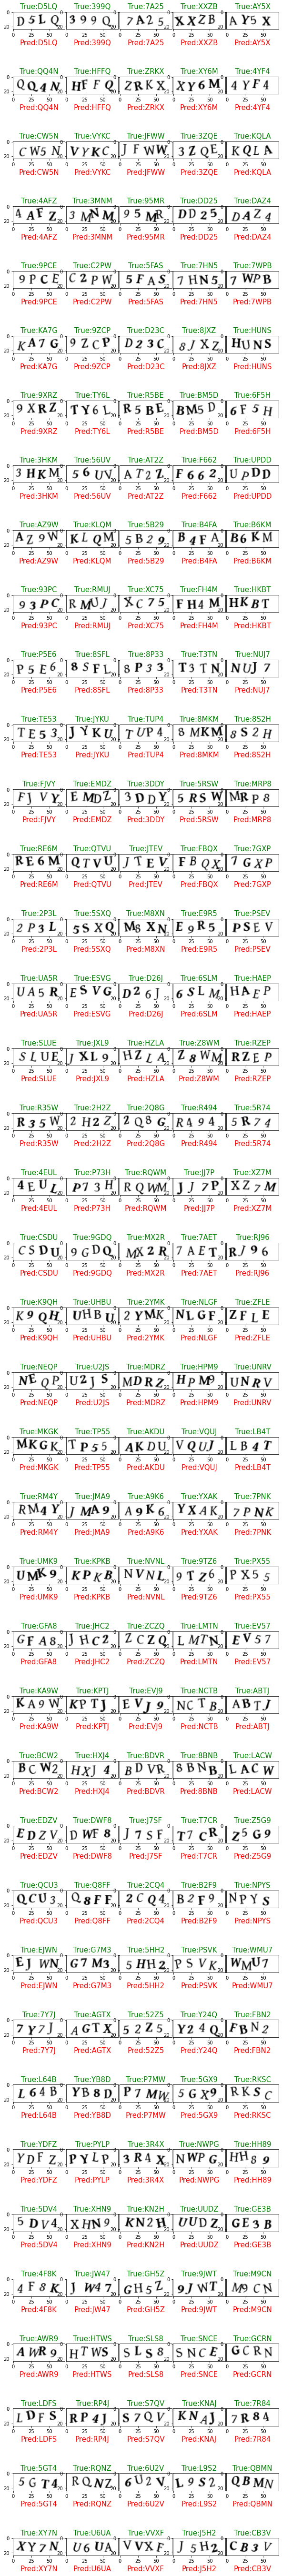

In [99]:
# WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,100))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS//5, 5)
gs1.update(wspace=0.025, hspace=0.025)
for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.title("True:"+valid_orig_txt[n+OFFSET], fontsize=15, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel("Pred:"+all_predictions[n+OFFSET], fontsize=15, color="red")


## Evaluation using CER, WER and SER

Tool to metrics calculation through data and label (string and string).
 * Calculation from Optical Character Recognition (OCR) metrics with editdistance.
This is borrowed from https://github.com/arthurflor23/handwritten-text-recognition/blob/master/src/data/evaluation.py

It is not needed to understand this function deeply, it only helps to calculate three evaluation metris:
- CER (Character Error Rate)
- WER (Word Error Rate)
- SER (Sequence Error Rate)

In [104]:
import string
import unicodedata
import editdistance

def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [105]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=valid_orig_txt,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])

This is a easy dataset so I got perfect score for absolutely the test set! Not even a challenge for CRNN power!

In [106]:
print(e_corpus)

Metrics:
Character Error Rate: 0.0
Word Error Rate:      0.0
Sequence Error Rate:  0.0


**So what do we learn from here**:
- CRNN + CTC is not that challenging, just want sure we follow above process step by step
- Keep our height and width is a power of 2 or at least even number is making our time much 
easier to divide by half (it is not really important, since it is related to design your model and preprocessing)
- The number bi LSTM paramater is larger the number of timestep since our biLSTM /2 will be at least the size of hidden node for each single LSTM.
- The max label length should be the same to the number of time steps, but some people report if they set it to be slightly lower than time step, it helps. 
But you should stick with the basics!
- The data is super clean and same image dimension. So for other datasets, maybe a bit of noise cleaning and binarization may help!


**Things to improve for other datasets**:
- Resize image logics with multiple image sizes (maybe as following):
    + find min, max of height and width
    + resize to a fixed height you want
    + calculate the max width of all resized images
    + padding to all images to that max width
- Combine the logic of preprocessing of train set and test set together
- Convert them to tfdataset pipeline (note that it is challenging since OpenCV won't work with tensor)
- Rework/redesign new CRNN model to fit with your new processed images. 